In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevandong","key":"c7ea20330645c70af3ad4bf050e88abf"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle --version

Kaggle API 1.6.17


In [ ]:
!kaggle competitions download -c deep-learning-spring-2025-project-1
!unzip -q deep-learning-spring-2025-project-1.zip -d ./data

deep-learning-spring-2025-project-1.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./data/cifar-10-python/cifar-10-batches-py/batches.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_1? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_2? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_3? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_4? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/data_batch_5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/readme.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar-10-python/cifar-10-batches-py/test_batch? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./data/cifar_test_nolabel.pkl? [

In [1]:
import pickle
import numpy as np

def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

batch_files = [
    'cifar-10-python/cifar-10-batches-py/data_batch_1',
    'cifar-10-python/cifar-10-batches-py/data_batch_2',
    'cifar-10-python/cifar-10-batches-py/data_batch_3',
    'cifar-10-python/cifar-10-batches-py/data_batch_4',
    'cifar-10-python/cifar-10-batches-py/data_batch_5'
]

test_file = 'cifar-10-python/cifar-10-batches-py/test_batch'

train_data = []
train_labels = []
test_data = []
test_labels = []

for file in batch_files:
    batch = unpickle(file)
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

test_batch = unpickle(test_file)
test_data.append(test_batch[b'data'])
test_labels.extend(test_batch[b'labels'])

train_data = np.concatenate(train_data, axis=0)
train_labels = np.array(train_labels)
train_data = train_data.reshape(-1, 3, 32, 32)
test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_data = test_data.reshape(-1, 3, 32, 32)
print(f'Training data shape: {train_data.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Testing data shape: {test_data.shape}')
print(f'Testing labels shape: {test_labels.shape}')

Training data shape: (50000, 3, 32, 32)
Training labels shape: (50000,)
Testing data shape: (10000, 3, 32, 32)
Testing labels shape: (10000,)


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)

test_data = torch.tensor(test_data, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

trainDataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testDataLoader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    # Using 3x3 square kernel, padding=1 ensure that the output size is the same as the input size.
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.sample = None
    if stride != 1 or in_channels != out_channels:
      self.sample = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
            )
  def forward(self, x):
    residualx = x
    if self.sample is not None:
      residualx = self.sample(x)

    out = self.conv1(x)
    out = self.bn1(out)
    out = nn.ReLU(inplace=True)(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out += residualx
    out = nn.ReLU(inplace=True)(out)

    return out

In [4]:
class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes = 10):
     super(ResNet, self).__init__()
     self.in_channels = 42

     self.conv1 = nn.Conv2d(3, 42, kernel_size=3, stride=1, padding=1, bias=False)
     self.bn1 = nn.BatchNorm2d(42)
     self.relu = nn.ReLU(inplace=True)
     self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

     self.layer1 = self._make_layer(block, 42, layers[0])
     self.layer2 = self._make_layer(block, 84, layers[1], stride=2)
     self.layer3 = self._make_layer(block, 168, layers[2], stride=2)
     self.layer4 = self._make_layer(block, 336, layers[3], stride=2)

     self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
     self.fc = nn.Linear(336, num_classes)

    #  self.in_channels = 64
    #  self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    #  self.bn1 = nn.BatchNorm2d(64)
    #  self.relu = nn.ReLU(inplace=True)
    #  self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    #  self.layer1 = self._make_layer(block, 64, layers[0])
    #  self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    #  self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    #  self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    #  self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    #  self.fc = nn.Linear(512, num_classes)



  def _make_layer(self, block, out_channels, blocks, stride=1):
     layers = [block(self.in_channels, out_channels, stride)]
     self.in_channels = out_channels
     layers += [block(out_channels, out_channels) for _ in range(1, blocks)]
     return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

layers = [2, 2, 2, 2]
model = ResNet(ResidualBlock, layers).cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
print(model)

ResNet(
  (conv1): Conv2d(3, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1

In [5]:
%pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 42, 224, 224]           1,134
       BatchNorm2d-2         [-1, 42, 224, 224]              84
              ReLU-3         [-1, 42, 224, 224]               0
         MaxPool2d-4         [-1, 42, 112, 112]               0
            Conv2d-5         [-1, 42, 112, 112]          15,876
       BatchNorm2d-6         [-1, 42, 112, 112]              84
            Conv2d-7         [-1, 42, 112, 112]          15,876
       BatchNorm2d-8         [-1, 42, 112, 112]              84
     ResidualBlock-9         [-1, 42, 112, 112]               0
           Conv2d-10         [-1, 42, 112, 112]          15,876
      BatchNorm2d-11         [-1, 42, 112, 112]              84
           Conv2d-12         [-1, 42, 112, 112]          15,876
      BatchNorm2d-13         [-1, 42, 112, 112]              84
    ResidualBlock-14         [-1, 42, 1

In [6]:
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(100):
  train_loss = 0.0
  test_loss = 0.0
  correct_train = 0
  total_train = 0
  correct_test = 0
  total_test = 0

  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

    _, predicted = torch.max(predicted_output, 1)  # Get class index with highest probability
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)

  model.eval()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      # if(i == 0):
      #   print(images[0])
      #   print(images.shape)
      #   print(images.type)
      #   print(images.device)
      #   print(images.min(), images.max())
      #   print(images.mean(), images.std())
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item()

      _, predicted = torch.max(predicted_output, 1)  # Get class index with highest probability
      correct_test += (predicted == labels).sum().item()
      total_test += labels.size(0)

  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)

  train_accuracy = correct_train / total_train
  test_accuracy = correct_test / total_test

  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  train_accuracy_history += [train_accuracy]
  test_accuracy_history += [test_accuracy]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}, Train Accuracy {train_accuracy}, Test Accuracy {test_accuracy}')

Epoch 0, Train loss 1.2059836618964324, Test loss 1.2698079119822023, Train Accuracy 0.56694, Test Accuracy 0.5693
Epoch 1, Train loss 0.8014756440735229, Test loss 0.7973582123874858, Train Accuracy 0.7206, Test Accuracy 0.7236
Epoch 2, Train loss 0.6377796489183251, Test loss 0.7490274820737778, Train Accuracy 0.77854, Test Accuracy 0.7416
Epoch 3, Train loss 0.5279588324715719, Test loss 0.7500319904202868, Train Accuracy 0.81646, Test Accuracy 0.7421
Epoch 4, Train loss 0.44425427239111925, Test loss 0.6880818762976653, Train Accuracy 0.84638, Test Accuracy 0.7704
Epoch 5, Train loss 0.363370273624311, Test loss 0.8303292904310166, Train Accuracy 0.87366, Test Accuracy 0.7361
Epoch 6, Train loss 0.3054467645352301, Test loss 0.6460914564360479, Train Accuracy 0.89272, Test Accuracy 0.7943
Epoch 7, Train loss 0.23985976590524855, Test loss 0.6535268406009977, Train Accuracy 0.91706, Test Accuracy 0.8003
Epoch 8, Train loss 0.20264161047537613, Test loss 0.8123639761262639, Train Acc

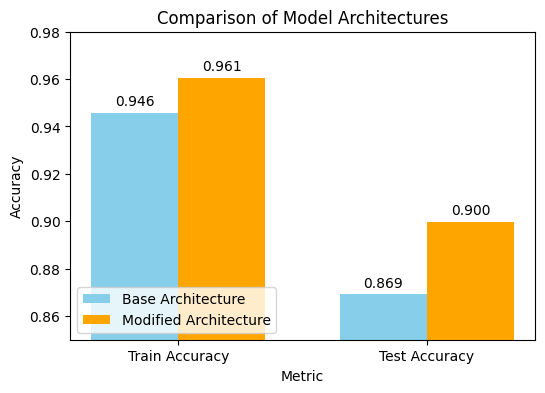

In [9]:
if __name__ == '__main__':
    train_accuracy_original_architecture = 0.9459
    test_accuracy_original_architecture = 0.8691
    train_accuracy_modified_architecture = 0.9605
    test_accuracy_modified_architecture = 0.8998
    import matplotlib.pyplot as plt
    import numpy as np

    # 数据
    labels = ['Train Accuracy', 'Test Accuracy']
    original_arch = [0.9459, 0.8691]
    modified_arch = [0.9605, 0.8998]

    # 设置柱状图位置
    x = np.arange(len(labels))
    width = 0.35  # 柱子的宽度

    # 画图
    fig, ax = plt.subplots(figsize=(6, 4))
    bars1 = ax.bar(x - width / 2, original_arch, width, label='Base Architecture', color='skyblue')
    bars2 = ax.bar(x + width / 2, modified_arch, width, label='Modified Architecture', color='orange')

    # 限制 y 轴范围（可调整）
    ax.set_ylim(0.85, 0.98)  # 让对比更明显

    # 添加标签和标题
    ax.set_xlabel('Metric')
    ax.set_ylabel('Accuracy')
    ax.set_title('Comparison of Model Architectures')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='lower left')  # 图例放在右下角

    # 在柱子上显示数值
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom')

    # 显示图像
    plt.show()
